Language Detection

Importing libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as  plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

The dataset which we are using needs some data cleaning.
we have to modify various things in our dataset like the delimiter used in our dataset is tab and it is not organized in proper manner.

Reading the dataset

In [2]:
data_set = pd.read_csv('sentences.csv', sep='\t',index_col=0, names=['lang','text'])

In [3]:
data_set.head()

,lang,text
1,cmn,我們試試看！
2,cmn,我该去睡觉了。
3,cmn,你在干什麼啊？
4,cmn,這是什麼啊？
5,cmn,今天是６月１８号，也是Muiriel的生日！


In [4]:
print('Rows in our dataset -> ',data_set.shape[0])
print('Unique languages -> ',data_set['lang'].nunique())

Rows in our dataset ->  10484130
Unique languages ->  410


As we can see out dataset is very huge, it has more than 10 Million rows with more than 400 languages so we will only take 6 languages in our model which are<br>
GERMAN, ENGLISH, FRENCH, ITALIAN, SPANISH, PORTUGUESE

In [5]:
df1 = data_set['text'].apply(lambda x: len(x))
print("Max length of text column -> ",df1.max())
print("Min length of text column ->",df1.min())

Max length of text column ->  56418
Min length of text column -> 1


There are variations in our sentences some of them are very small like 1 character long and some of them are very long like 50000 characters long<br>
So we will take only those columns which are more than 20 words and less than 200 words

In [6]:
data_set = data_set[[True if 20<=len(s)<=200 else False for s in data_set['text']]]
languages = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
data_set = data_set[data_set['lang'].isin(languages)]

In [7]:
print("Count of each language in our dataset :")
count_of_languages_sentences = pd.DataFrame(columns=['lang','count'])
counts = []
for i in languages:
    counts.append(len(data_set[data_set.lang == i]))
    print(i," -> ", len(data_set[data_set.lang == i]))

Count of each language in our dataset :
deu  ->  551964
eng  ->  1489134
fra  ->  457937
ita  ->  704315
por  ->  354577
spa  ->  328080


[(30000.0, 800000.0)]

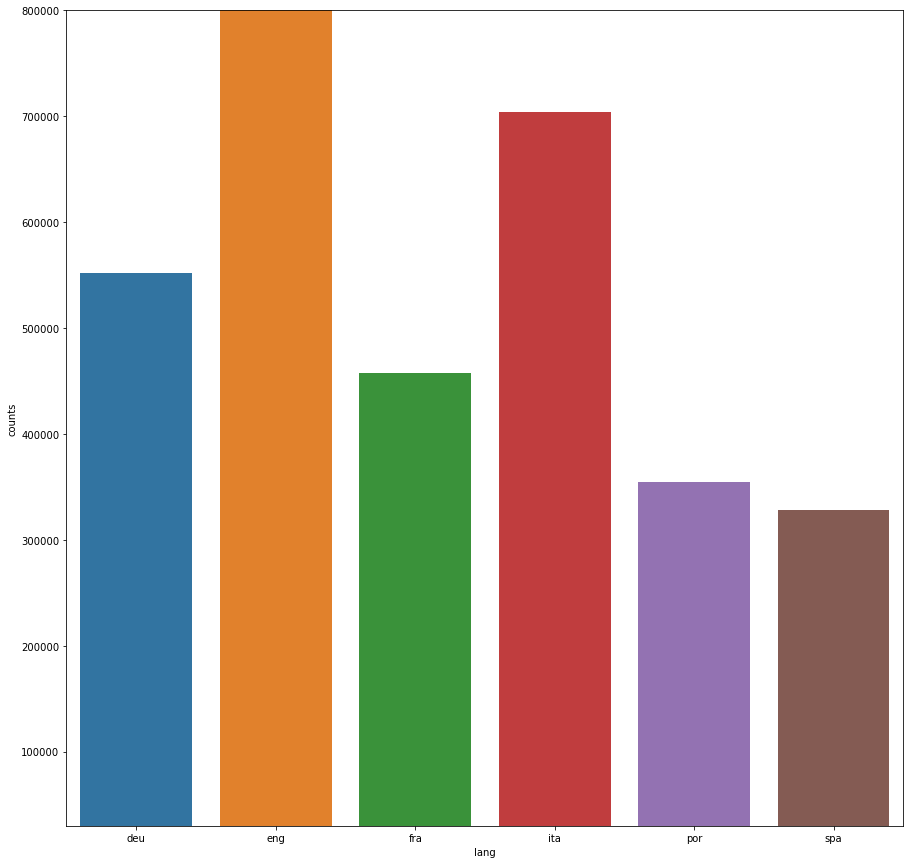

In [8]:
count_of_languages_sentences['lang'] = languages
count_of_languages_sentences['counts'] = counts
plt.figure(figsize=(15,15))
dd = sns.barplot(x=count_of_languages_sentences.lang, y=count_of_languages_sentences.counts)
dd.set(ylim = (30000,800000))

As we can see all of our selected languages have more than 100k rows so we will randomly select 50k rows from each languages.<br>
We will create a new csv file which will store our selected rows from which we will train our model<br>

We will divide our dataset in 3<br>
Train -> To Train our model<br>
Valid -> To Vaidate our model<br>
Test -> To Test our model<br>

In [12]:
data_set_trim = pd.DataFrame(columns=['lang','text'])
for i in languages:
    data_set_trim = pd.concat([data_set_trim, data_set[data_set.lang == i].sample(50000, random_state = 100)])
data_set_shuffle = data_set_trim.sample(frac=1)
final_dataset = pd.DataFrame(data_set_shuffle)
final_dataset.to_csv('final_dataset.csv')
final_dataset.reset_index(drop=True, inplace=True)
final_dataset.head()

,lang,text
0,fra,Combien y a-t-il de poils sur la queue d'un ch...
1,spa,Déjame presentarte a un buen dentista.
2,por,Eu lhe direi isto mais uma vez.
3,por,Eu sou claustrofóbico.
4,eng,When's the last time you ate?


In [17]:
train = final_dataset[0:210000]
valid = final_dataset[210000:270000]
test = final_dataset[270000:300000]
print("Training dataset -> ", train.shape)
print("Testing dataset -> ", test.shape)
print("Validating dataset -> ", valid.shape)

Training dataset ->  (210000, 2)
Testing dataset ->  (30000, 2)
Validating dataset ->  (60000, 2)


We have filtered our dataset and divided it. Now for the next part we have to Some Feature engineering

We will be using Bag of words. for feature engineering<br>
First we need to create a function which return trigrams of 200 frequent words

In [18]:
def get_trigrams(corpus, n_feat=200):
    vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (3,3), max_features = n_feat)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    return feature_names

We need to create a custom vocabulary list. To create this list first we need to obtain trigrams from each language. add them to a set.<br>
In the end, as the languages share some common trigrams, we have a set of 666 unique trigrams.<br>
Now we are ready to create our vocabulary list using our set
we run a loop using enumerate in our set and push our set in a dict using enumerate to produce indexes.

In [19]:
features_set = set()
features = {}
for l in languages:
    corpus = train[train.lang==l]['text']
    trigrams = get_trigrams(corpus)
    features[l] = trigrams
    features_set.update(trigrams)

vocab = dict()
for i,f in enumerate(features_set):
    vocab[f] = i

Now our vocaubulary list has been created(vocab), and we will use our vocabulary list in CountVectorizer to create a feature matrix. which then we will use to train our model.

In [20]:
vectorizer = CountVectorizer(analyzer='char',ngram_range=(3,3),vocabulary=vocab)
corpus = train['text']
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
train_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)

Vocab = Stores the string and its index in dict format

In [21]:
vocab

{'ia.': 0,
 'ad ': 1,
 'ind': 2,
 'n l': 3,
 'em ': 4,
 'man': 5,
 'mon': 6,
 'th ': 7,
 'you': 8,
 'pro': 9,
 'd t': 10,
 'ehr': 11,
 'oi ': 12,
 'ito': 13,
 'ai ': 14,
 'tom': 15,
 'cas': 16,
 'die': 17,
 'eu ': 18,
 'am ': 19,
 'o e': 20,
 's m': 21,
 'uie': 22,
 ' wh': 23,
 "on'": 24,
 ' ge': 25,
 'ter': 26,
 'sta': 27,
 'iss': 28,
 'une': 29,
 'oir': 30,
 'oin': 31,
 'hab': 32,
 ' wa': 33,
 'chi': 34,
 'ión': 35,
 'ano': 36,
 'voi': 37,
 ' em': 38,
 'sic': 39,
 'ou ': 40,
 'per': 41,
 'a n': 42,
 ' of': 43,
 'das': 44,
 ' si': 45,
 ' in': 46,
 ' o ': 47,
 'ava': 48,
 'ill': 49,
 'n m': 50,
 'can': 51,
 'ría': 52,
 'wei': 53,
 "l'a": 54,
 'sa ': 55,
 'n b': 56,
 ' pa': 57,
 'ued': 58,
 ' lo': 59,
 'o n': 60,
 'des': 61,
 'li ': 62,
 'nta': 63,
 ' so': 64,
 'omm': 65,
 'ent': 66,
 'aus': 67,
 'o m': 68,
 'och': 69,
 'pre': 70,
 'rai': 71,
 'is ': 72,
 're ': 73,
 'hin': 74,
 'ica': 75,
 'e, ': 76,
 'war': 77,
 'wie': 78,
 'o t': 79,
 ' ti': 80,
 'anc': 81,
 'las': 82,
 'tra': 83,
 '

X = stores our row and then column and then the count of substring occurences.<br>
(0,21) 1 => it means first row and twentyfirst column has 1 occurence and to see to which string our 21 column refers to we have to refer our vocab.<br>



Row means sentence number<br>
column means their index<br>

In [22]:
print(X[0][0])

  (0, 109)	1
  (0, 128)	1
  (0, 132)	1
  (0, 133)	1
  (0, 135)	1
  (0, 237)	1
  (0, 243)	1
  (0, 249)	1
  (0, 286)	1
  (0, 296)	1
  (0, 388)	1
  (0, 393)	1
  (0, 401)	1
  (0, 451)	1
  (0, 458)	1
  (0, 478)	1
  (0, 540)	1
  (0, 554)	1
  (0, 565)	1
  (0, 571)	1
  (0, 593)	1
  (0, 636)	1
  (0, 637)	1
  (0, 661)	1


As we can see our train_feat is ready it stores occurence of subtring in string

In [24]:
print(train_feat.head(1))

   ia.  ad   ind  n l  em   man  mon  th   you  pro  ...   co   il  om    it  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   lla   qu   al  tru  st   tou  
0    0    1    0    0    0    0  

[1 rows x 666 columns]


Before training our model we need to scale our feature matrix.


We will be using Min-max scaling<br>
we need to find min, of our train_feat<br>
Min-max scaling = (x - min(x))/(max(x) - min(x))

In [25]:
train_min = train_feat.min()
train_max = train_feat.max()
train_feat = (train_feat - train_min)/(train_max-train_min)
train_feat['lang'] = list(train['lang'])

In [26]:
train_feat

,ia.,ad,ind,n l,em,man,mon,th,you,pro,...,il,om,it,lla,qu,al,tru,st,tou,lang
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.000,0.0,fra
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,spa
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,por
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,por
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.125,0.0,eng
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,ita
209996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,eng
209997,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,ita
209998,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,por


We need to create feature matrix for validation and testing dataset<br>
We need to be carefull about the vocabulary list and min/max values because they need to be same across the dataset(train, test, validation). This is to avoid any data leakage.

For validation dataset

In [27]:
corpus = valid['text']
X = vectorizer.fit_transform(corpus)

valid_feat = pd.DataFrame(data=X.toarray(), columns=feature_names)
valid_feat = (valid_feat - train_min)/(train_max-train_min)
valid_feat['lang'] = list(valid['lang'])

For testing dataset.

In [28]:
corpus = test['text']
X = vectorizer.fit_transform(corpus)

test_feat = pd.DataFrame(data=X.toarray(), columns=feature_names)
test_feat = (test_feat - train_min)/(train_max - train_min)
test_feat['lang'] = list(test['lang'])

In [29]:
features['deu'].shape

(200,)

<AxesSubplot:>

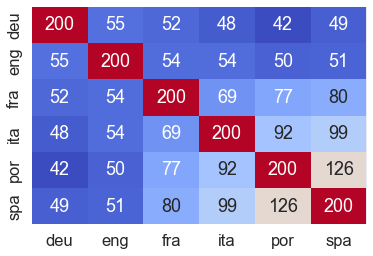

In [30]:
mat = []
for i in languages:
    vec = []
    for j in languages:
        l1 = features[i]
        l2 = features[j]
        intersec = [l for l in l1 if l in l2]
        vec.append(len(intersec))
        #print(vec)
    mat.append(vec)
#print(mat)
conf_matrix = pd.DataFrame(mat, columns=languages, index=languages)
sns.set(font_scale = 1.5)
sns.heatmap(conf_matrix, cmap='coolwarm', annot=True, fmt='.5g',cbar=False)

Now we are ready to make our model.


In [41]:
encoder = LabelEncoder()
encoder.fit(['deu', 'eng', 'fra', 'ita', 'por', 'spa'])

def encode(y):
    y_encoded = encoder.transform(y)
    y_dummy = np_utils.to_categorical(y_encoded)
    return y_dummy

encoder.fit assigns a number to our language like deu is 0, eng is 1 and soo on.<br>
np_utils.to_categorical makes a 2d array each consisting of 6 rows and each row represents a language 

In [42]:
x = train_feat.drop('lang',axis = 1)
y = encode(train_feat['lang'])
print(x)

        ia.  ad   ind  n l  em        man  mon  th        you  pro  ...   co  \
0       0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  ...  0.0   
1       0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  ...  0.0   
2       0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  ...  0.0   
3       0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  ...  0.0   
4       0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.111111  0.0  ...  0.0   
...     ...  ...  ...  ...  ...       ...  ...  ...       ...  ...  ...  ...   
209995  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  ...  0.0   
209996  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  ...  0.0   
209997  0.0  0.0  0.0  0.0  0.0  0.166667  0.0  0.0  0.000000  0.0  ...  0.0   
209998  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  ...  0.0   
209999  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  ...  0.0   

         il  om    it  lla     qu   al 

In [43]:
x_val = valid_feat.drop('lang',axis=1)
y_val = encode(valid_feat['lang'])

Hyperparameter tuning.

For Hyperparameter tuning I changed.<br>
Number of epochs                    
Number of batch-size<br>
Number of hidden layer

In [45]:
def fit_model(nodes,epochs,batch_size):
    model = Sequential()
    model.add(Dense(nodes[0], input_dim=666, activation='relu'))
    model.add(Dense(nodes[1], activation='relu'))
    model.add(Dense(nodes[2], activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(x, y, epochs=epochs, batch_size=batch_size) #fit ANN
    
    train_acc = model.evaluate(x, y)
    val_acc = model.evaluate(x_val, y_val)
    
    return round(train_acc[1]*100,2),round(val_acc[1]*100,2)

In [ ]:
nodes = [[100,100,50],[200,200,100],[300,200,100],[500,500,250]]
epochs = [1,2,3,4]
batch_size = [10,100,1000]

results = []
i = 0

for n in nodes:
    print("MODEL: ", i)
    for e in epochs:
        for b in batch_size:
            result = {}
            
            result['model'] = i
            result['nodes'] = n
            result['epochs'] = e
            result['batch_size'] = b
            result['train'], result['valid'] = fit_model(n,e,b)
            
            results.append(result)
            i+= 1

results_final = pd.DataFrame(results)